# GETTING DATA AND IMPORTING LIBRARIES

We import all basic libraries required to manipulate the data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

We import all ML algorithms and metric to study the efficiency of the algorithms.

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

In [4]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Import all data

In [5]:
data = pd.read_csv('creditCard_applications.csv')
records = pd.read_csv('credit_record.csv')

In [6]:
data.head(1)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0


In [7]:
records.head(1)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X


# DATA UNDERSTANDING AND PREPROCESSING

## Combining two datasets based on the ID

Calculate the start month for each ID and merge both datasets

In [8]:
start_month = pd.DataFrame(records.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
start = start_month.rename(columns={'MONTHS_BALANCE':'account_age'})
df = pd.merge(data,start,how="left",on="ID")

## Understanding the data

In [9]:
print("Rows and columns: ",df.shape)

Rows and columns:  (355485, 19)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355485 entries, 0 to 355484
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   355485 non-null  int64  
 1   CODE_GENDER          355485 non-null  object 
 2   FLAG_OWN_CAR         355485 non-null  object 
 3   FLAG_OWN_REALTY      355485 non-null  object 
 4   CNT_CHILDREN         355485 non-null  int64  
 5   AMT_INCOME_TOTAL     355485 non-null  float64
 6   NAME_INCOME_TYPE     355485 non-null  object 
 7   NAME_EDUCATION_TYPE  355485 non-null  object 
 8   NAME_FAMILY_STATUS   355485 non-null  object 
 9   NAME_HOUSING_TYPE    355485 non-null  object 
 10  DAYS_BIRTH           355485 non-null  int64  
 11  DAYS_EMPLOYED        355485 non-null  int64  
 12  FLAG_MOBIL           355485 non-null  int64  
 13  FLAG_WORK_PHONE      355485 non-null  int64  
 14  FLAG_PHONE           355485 non-null  int64  
 15  FLAG_EMAIL       

In [11]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,account_age
count,3.554850e+05,355485.000000,3.554850e+05,355485.000000,355485.000000,355485.0,355485.000000,355485.000000,355485.000000,355484.000000,36105.000000
mean,5.852110e+06,0.428612,1.879844e+05,-15999.543910,60090.216783,1.0,0.210709,0.292125,0.106682,2.197067,-26.171555
std,4.623364e+05,0.726563,1.108551e+05,4175.450496,138368.985411,0.0,0.407813,0.454740,0.308709,0.898523,16.532223
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.471051e+06,0.000000,1.215000e+05,-19474.000000,-3118.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.907263e+06,0.000000,1.620000e+05,-15626.000000,-1483.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,6.196492e+06,1.000000,2.250000e+05,-12534.000000,-380.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,6.841875e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


In [12]:
print("Columns:",df.columns.values)

Columns: ['ID' 'CODE_GENDER' 'FLAG_OWN_CAR' 'FLAG_OWN_REALTY' 'CNT_CHILDREN'
 'AMT_INCOME_TOTAL' 'NAME_INCOME_TYPE' 'NAME_EDUCATION_TYPE'
 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'FLAG_MOBIL' 'FLAG_WORK_PHONE' 'FLAG_PHONE' 'FLAG_EMAIL'
 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'account_age']


Rename column names for better understanding

In [13]:
df.rename(columns={'CODE_GENDER':'gender','FLAG_OWN_CAR':'own_car','FLAG_OWN_REALTY':'own_realty',
                         'CNT_CHILDREN':'childcnt','AMT_INCOME_TOTAL':'income',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'fmstatus',
                        'NAME_HOUSING_TYPE':'housetp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'incometp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','FLAG_MOBIL':'mbl','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occtp','DAYS_BIRTH':'age','DAYS_EMPLOYED':'days_employed'
                        },inplace=True)
df.head()

,ID,gender,own_car,own_realty,childcnt,income,incometp,edutp,fmstatus,housetp,age,days_employed,mbl,wkphone,phone,email,occtp,famsize,account_age
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355485 entries, 0 to 355484
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             355485 non-null  int64  
 1   gender         355485 non-null  object 
 2   own_car        355485 non-null  object 
 3   own_realty     355485 non-null  object 
 4   childcnt       355485 non-null  int64  
 5   income         355485 non-null  float64
 6   incometp       355485 non-null  object 
 7   edutp          355485 non-null  object 
 8   fmstatus       355485 non-null  object 
 9   housetp        355485 non-null  object 
 10  age            355485 non-null  int64  
 11  days_employed  355485 non-null  int64  
 12  mbl            355485 non-null  int64  
 13  wkphone        355485 non-null  int64  
 14  phone          355485 non-null  int64  
 15  email          355485 non-null  int64  
 16  occtp          246917 non-null  object 
 17  famsize        355484 non-nul

## Assigning binary values to the determinant variable

For records where the customer has not paid off the credit even after 60 days, they are considered high risk customers.

In [15]:
records['dep_value'] = None
records['dep_value'][records['STATUS'] =='2']='Yes'
records['dep_value'][records['STATUS'] =='3']='Yes'
records['dep_value'][records['STATUS'] =='4']='Yes'
records['dep_value'][records['STATUS'] =='5']='Yes'

<ipython-input-15-e05ae02363fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['dep_value'][records['STATUS'] =='2']='Yes'
<ipython-input-15-e05ae02363fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['dep_value'][records['STATUS'] =='3']='Yes'
<ipython-input-15-e05ae02363fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['dep_value'][records['STATUS'] =='4']='Yes'
<ipython-input-15-e05ae02363fc>:5: Setti

In [16]:
# Count the records for each ID in records table
temp=records.groupby('ID').count()

# If the customer is high risk then set dep_value to 'Yes' else 'No'
temp['dep_value'][temp['dep_value'] > 0]='Yes'
temp['dep_value'][temp['dep_value'] == 0]='No'
temp = temp[['dep_value']]

# Join this new dataframe with our df datafram
df=pd.merge(df,temp,how='inner',on='ID')
df['target']=df['dep_value']
df.loc[df['target']=='Yes','target']=1
df.loc[df['target']=='No','target']=0

df.drop('dep_value',axis=1,inplace=True)

In [17]:
df.head(1)

,ID,gender,own_car,own_realty,childcnt,income,incometp,edutp,fmstatus,housetp,age,days_employed,mbl,wkphone,phone,email,occtp,famsize,account_age,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0


## Handling null values in our dataset

Look up for all null values in our data frame.

In [18]:
df.isnull().sum()

ID                   0
gender               0
own_car              0
own_realty           0
childcnt             0
income               0
incometp             0
edutp                0
fmstatus             0
housetp              0
age                  0
days_employed        0
mbl                  0
wkphone              0
phone                0
email                0
occtp            11214
famsize              0
account_age          0
target               0
dtype: int64

Remove all records with null values

In [19]:
df.dropna()
df = df.mask(df == 'NULL').dropna()

Check for null values again

In [20]:
df.isnull().sum()

ID               0
gender           0
own_car          0
own_realty       0
childcnt         0
income           0
incometp         0
edutp            0
fmstatus         0
housetp          0
age              0
days_employed    0
mbl              0
wkphone          0
phone            0
email            0
occtp            0
famsize          0
account_age      0
target           0
dtype: int64

## Data after Pre-processing




In [21]:
df.shape

(24891, 20)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24891 entries, 2 to 36103
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             24891 non-null  int64  
 1   gender         24891 non-null  object 
 2   own_car        24891 non-null  object 
 3   own_realty     24891 non-null  object 
 4   childcnt       24891 non-null  int64  
 5   income         24891 non-null  float64
 6   incometp       24891 non-null  object 
 7   edutp          24891 non-null  object 
 8   fmstatus       24891 non-null  object 
 9   housetp        24891 non-null  object 
 10  age            24891 non-null  int64  
 11  days_employed  24891 non-null  int64  
 12  mbl            24891 non-null  int64  
 13  wkphone        24891 non-null  int64  
 14  phone          24891 non-null  int64  
 15  email          24891 non-null  int64  
 16  occtp          24891 non-null  object 
 17  famsize        24891 non-null  float64
 18  account_age

Get list of unique values for all features

In [23]:
for i in df.columns:
    if df[i].dtype==object:
      print(i,": ",df[i].unique(),"\n")

gender :  ['M' 'F'] 

own_car :  ['Y' 'N'] 

own_realty :  ['Y' 'N'] 

incometp :  ['Working' 'Commercial associate' 'State servant' 'Student'] 

edutp :  ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree'] 

fmstatus :  ['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow'] 

housetp :  ['House / apartment' 'Rented apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment'] 

occtp :  ['Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Private service staff' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff'] 

target :  [0 1] 



# EDA

In [24]:
colors = ["lightcoral","indianred","lightsalmon","sandybrown","khaki","lightgreen","limegreen","skyblue","mediumaquamarine","turquoise","thistle","pink"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

## Analysing binary features

Understand the skewness in data

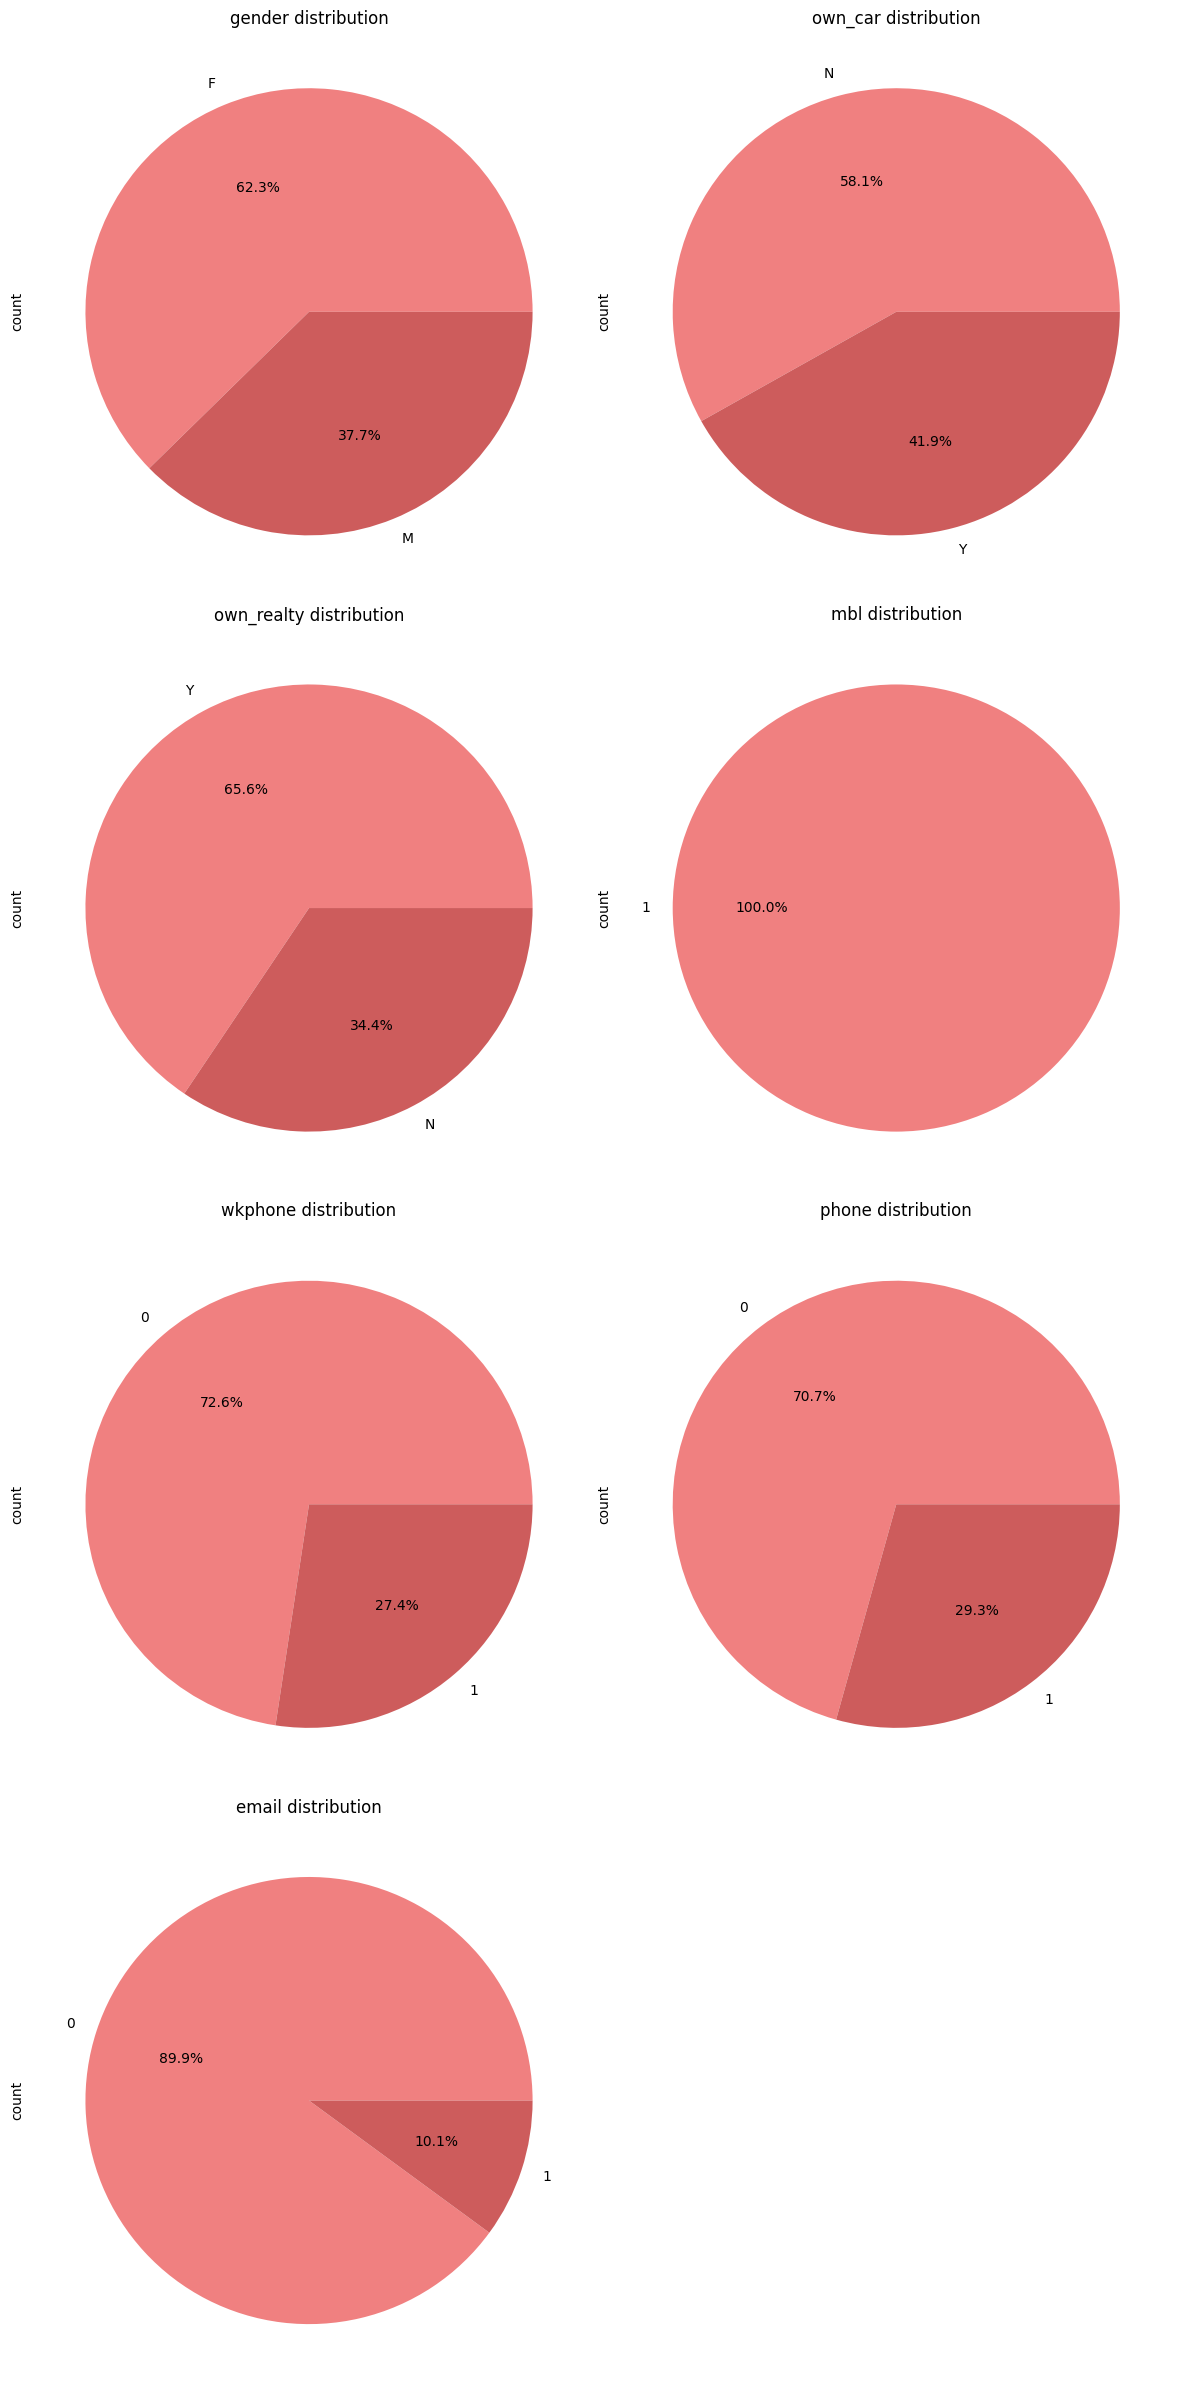

In [25]:
bin_features = ['gender', 'own_car','own_realty', 'mbl', 'wkphone','phone','email']

def plot_pie_charts(df, bin_features):
    num_rows = (len(bin_features) + 1) // 2
    plt.figure(figsize=(12, 6*num_rows))

    for i, feature in enumerate(bin_features, start=1):
        plt.subplot(num_rows, 2, i)
        df[feature].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'{feature} distribution')

    plt.tight_layout()
    plt.show()

plot_pie_charts(df,bin_features)

We can see that:
*   'mbl' feature is unfit for analysing the data and may affect the efficiency of our ML algorithms later.
*   most of the features are biased

Also we can observe that most applicants are,
*   Females
*   own car
*   own realty

## Analysing continuous features

To get information about the frequency distribution for each category in dataframe.

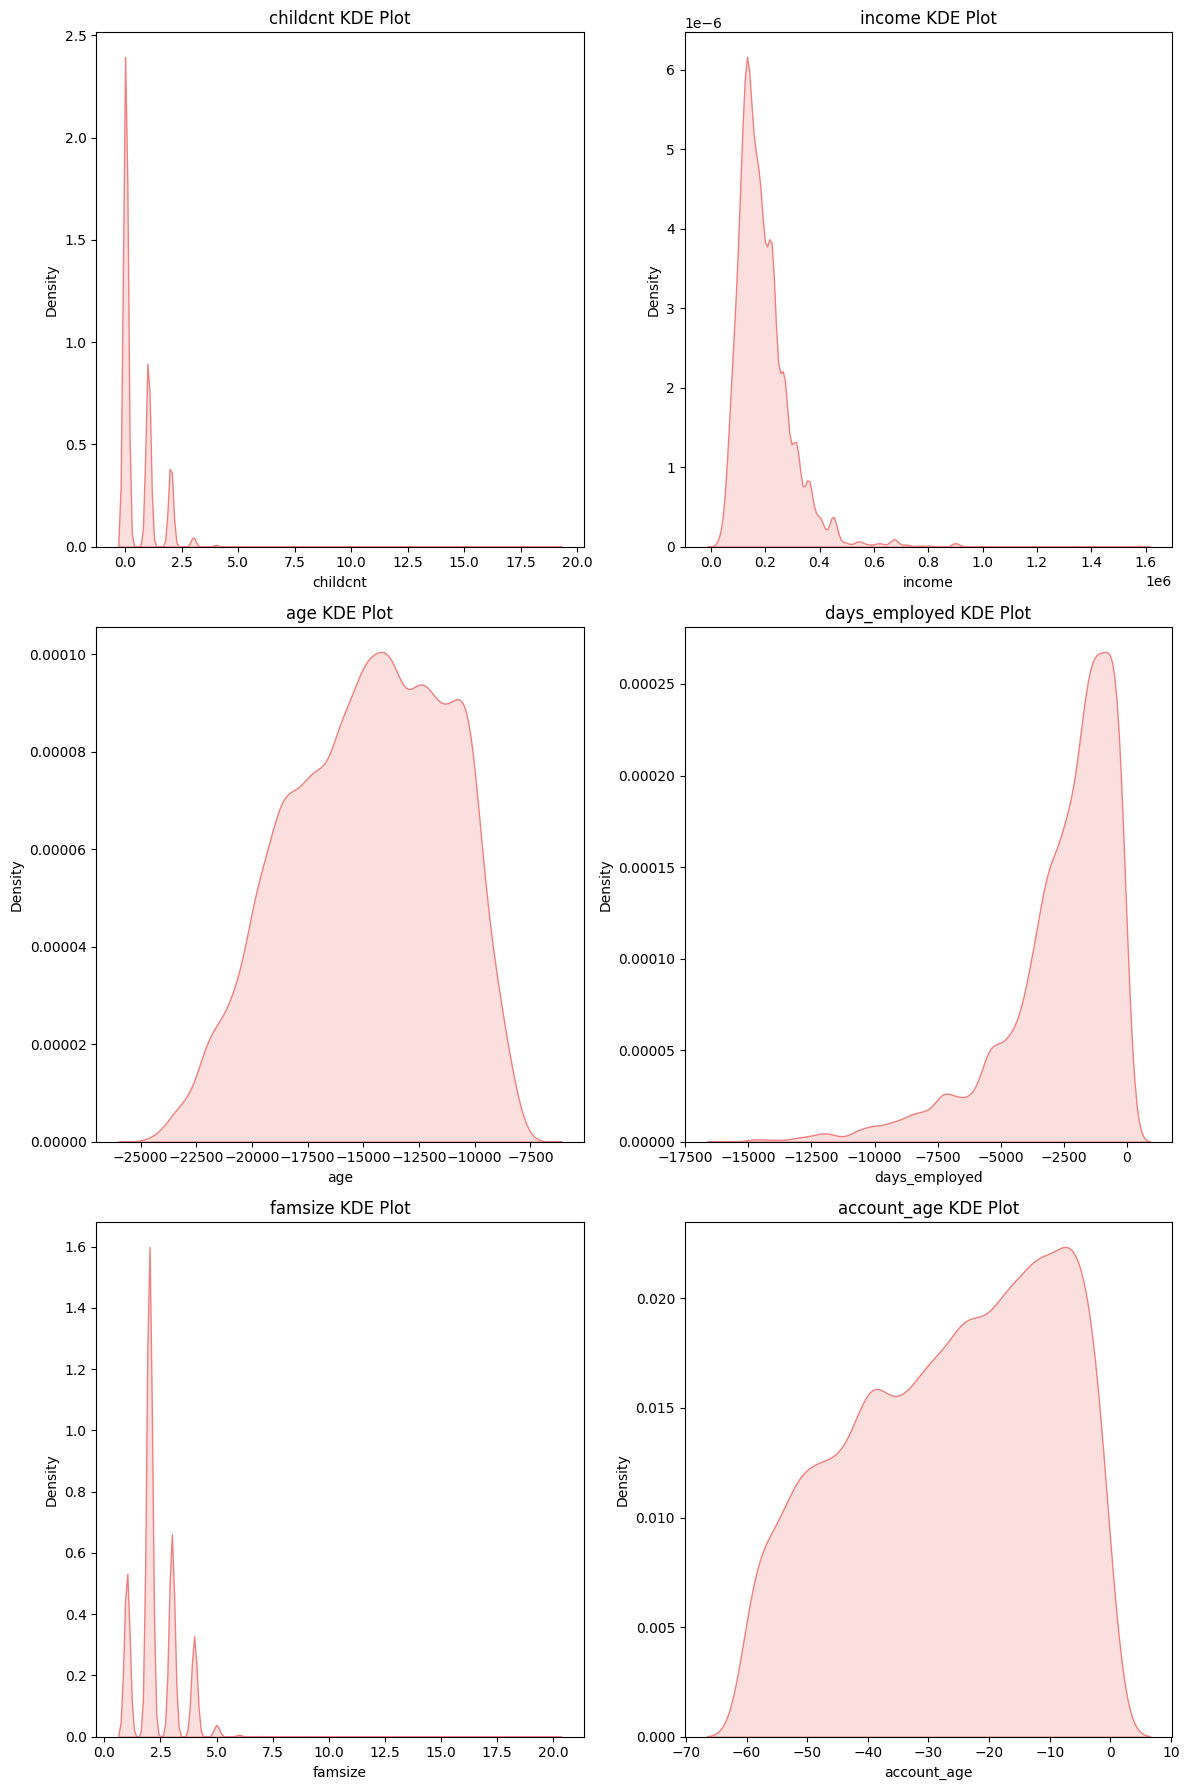

In [26]:
cont_features = [ 'childcnt','income','age','days_employed','famsize','account_age']

def plot_kde_plots(df, cont_features):
    num_rows = (len(cont_features) + 1) // 2
    plt.figure(figsize=(12, 6*num_rows))

    for i, feature in enumerate(cont_features, start=1):
        plt.subplot(num_rows, 2, i)
        sns.kdeplot(df[feature], fill=True)
        plt.title(f'{feature} KDE Plot')

    plt.tight_layout()
    plt.show()

plot_kde_plots(df,cont_features)

We can see that
*   childcnt, income, and famsize features are left skewed
*   days_employed feature is right skewed
*   days_birth shows symmetric distribution






## Analysing categorical features

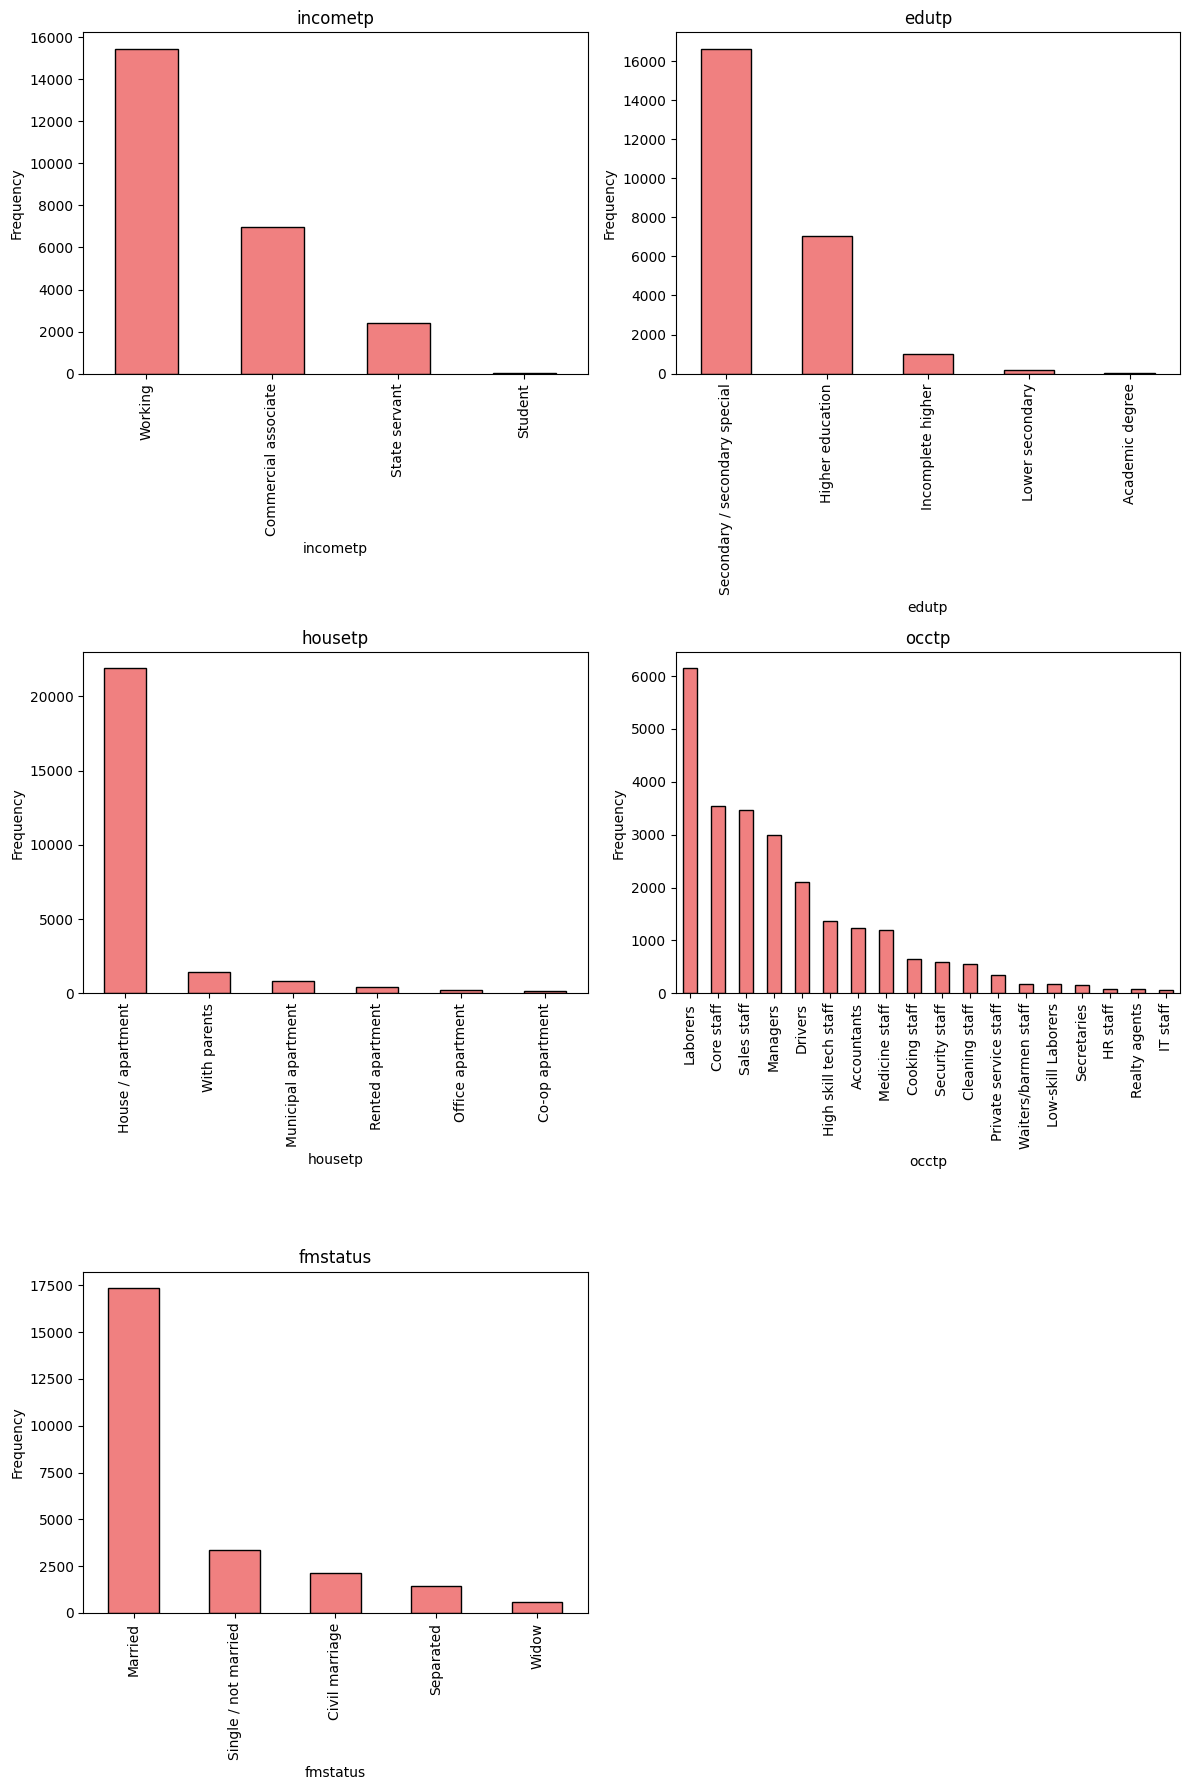

In [27]:
cat_features = ['incometp','edutp','housetp','occtp','fmstatus']

def plot_bar_plots(df, cat_features):
    num_rows = (len(cat_features) + 1) // 2
    plt.figure(figsize=(12, 6*num_rows))

    for i, feature in enumerate(cat_features, start=1):
        plt.subplot(num_rows, 2, i)
        df[feature].value_counts().plot(kind='bar', edgecolor='black')
        plt.title(feature)
        # plt.xlabel("Category")
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

plot_bar_plots(df,cat_features)

By analysing categorical features we can understand relationship between features, identify biases within the data, and analysing the impact of these features on the overall credit card approval decision.

Here we can see that most applicants are
*   married people
*   working
*   and have atleast secondary level of education





## Bivariate/Multivariate analysis

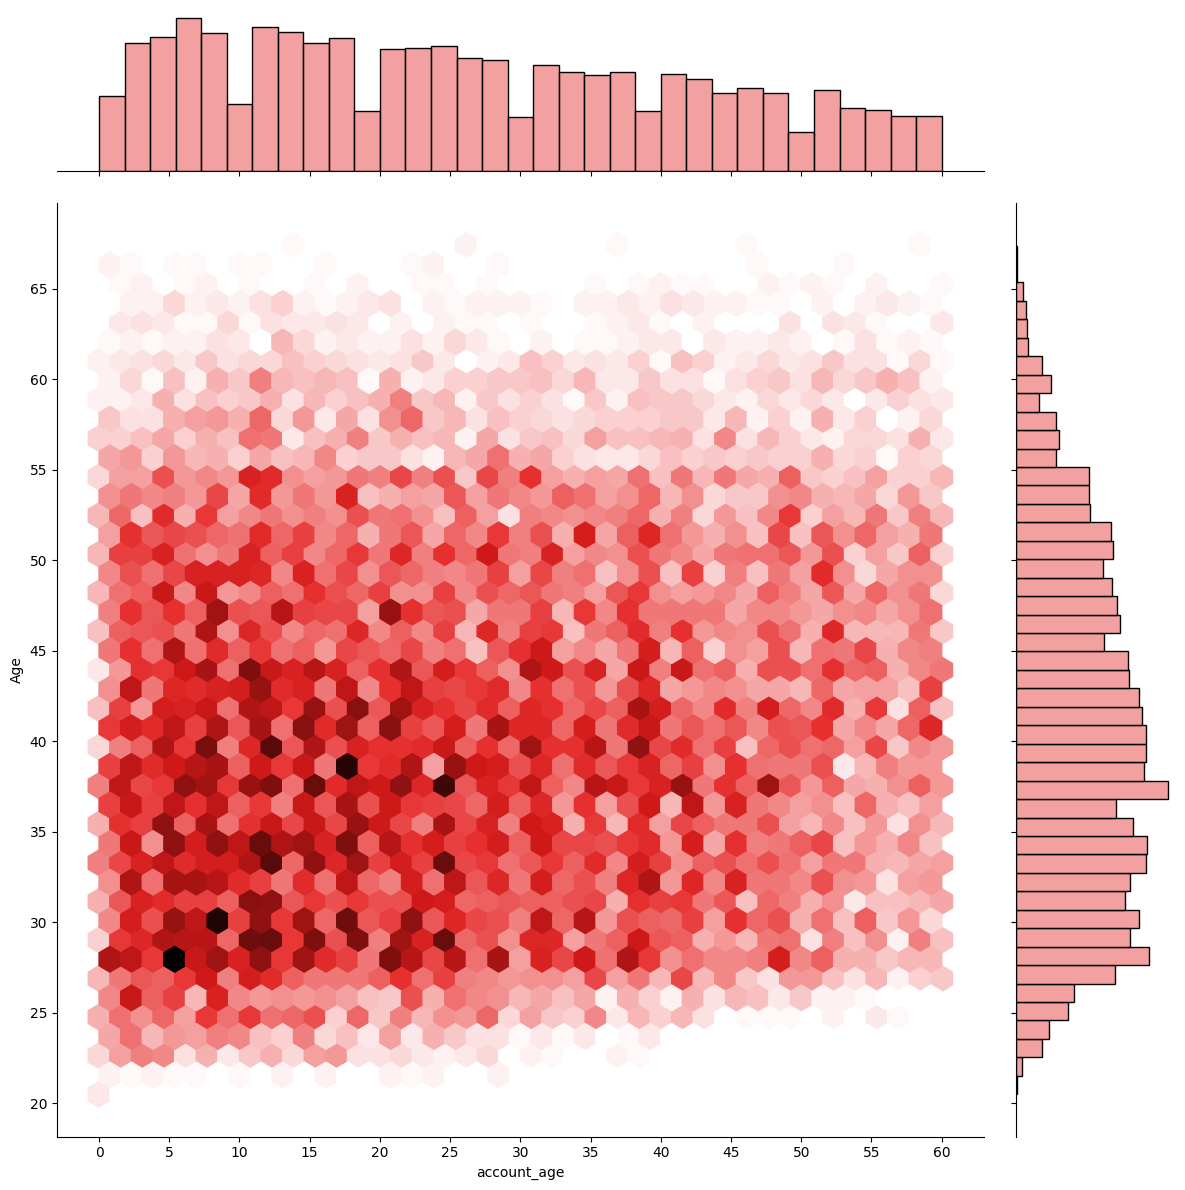

In [28]:
y_age = np.abs(df['age'])/365.25

sns.jointplot(data=df,x = np.abs(df['account_age']),y = y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

We can observe from above graph that most credit card applicants are,
*   between ages 27 and 45
*   have account since 5 to 25 months



Numerical and numerical

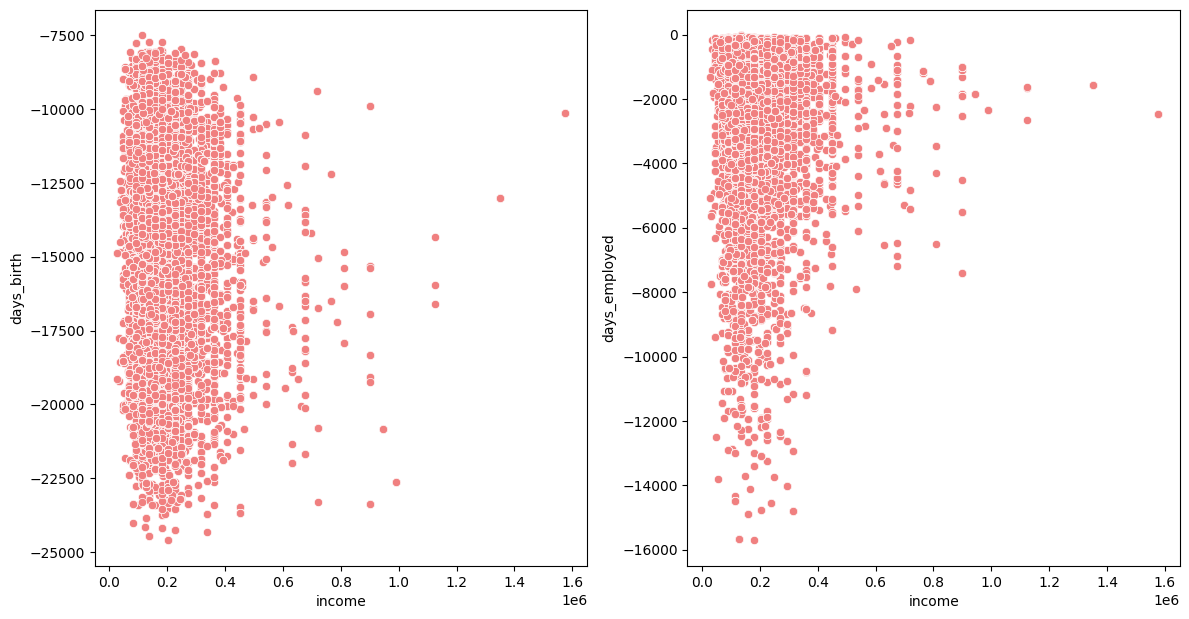

In [29]:
num_rows = 2
plt.figure(figsize=(12, 6*num_rows))

plt.subplot(num_rows, 2, 1)
sns.scatterplot(df,x = df["income"], y = df["age"])
# plt.title(feature)
# plt.xlabel("Category")
plt.ylabel("days_birth")

plt.subplot(num_rows, 2, 2)
sns.scatterplot(df,x = df["income"], y = df["days_employed"])
# plt.title(feature)
# plt.xlabel("Category")
plt.ylabel("days_employed")


plt.tight_layout()
plt.show()


Numerical and Categorical

Text(0.5, 1.0, 'Income by Income Type')

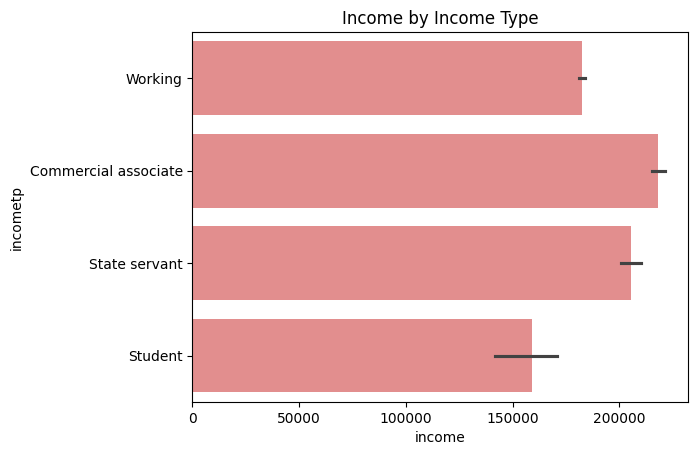

In [30]:
sns.barplot(df,x = df['income'],y = df['incometp'])
plt.title("Income by Income Type")

Text(0.5, 1.0, 'Income by Occupation Type')

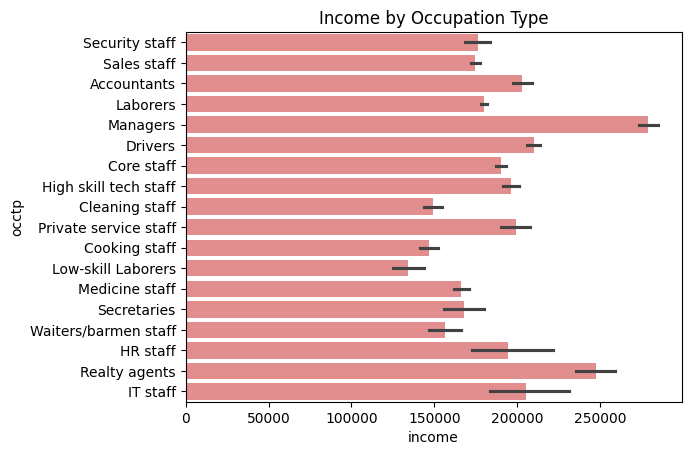

In [31]:
sns.barplot(df,x = df['income'],y = df['occtp'])
plt.title("Income by Occupation Type")

Text(0.5, 1.0, 'Income by Income Type')

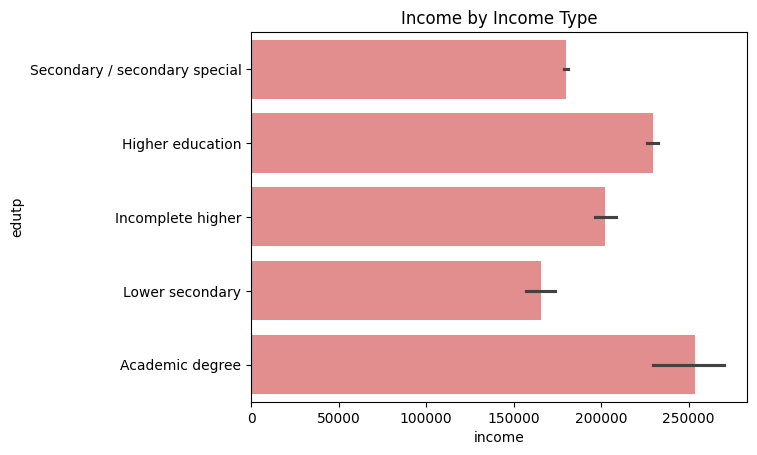

In [32]:
sns.barplot(df,x = df['income'],y = df['edutp'])
plt.title("Income by Income Type")

Categorical and categorical

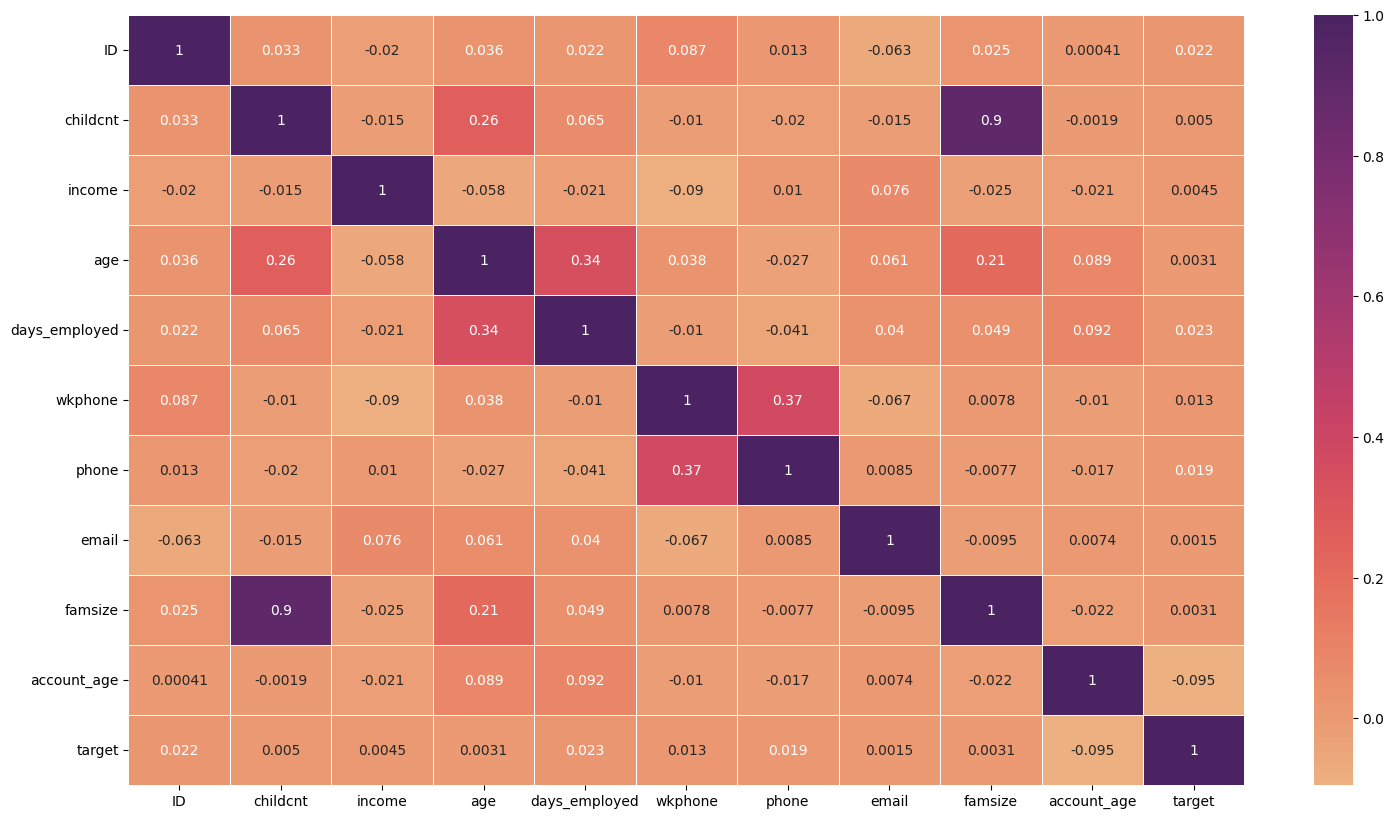

In [33]:
target_int = df['target'].astype('int32')
df_copy_corr = pd.concat([df.drop(['mbl','target','gender','own_car','own_realty','incometp','edutp','housetp','occtp','fmstatus'], axis=1),target_int],axis=1).corr()

# mask = np.zeros_like(df_copy_corr, dtype='bool')
# mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(df_copy_corr, annot=True, cmap='flare', linewidths=.5)
# plot the heatmap
plt.show()

From above heatmap we can observe that,
*   no feature is strongly correlated with target feature
*   high correlation between famsize and childcnt, as more children leads to bigger families
*   age has positive correlation with famsize, child count and days_employed


From the above visual analysis we can infer that,
*   Typical applicant is a female in her 40’s , married, has been employed for about five years, has completed her secondary education, own a property.
*   Also age and income have minimal or no effect on the target variable
*   Most applicants are between 27 and 45 years of age and have account since 5 to 25 months.

# PREPARING DATA FOR ML

## Remove features

Remove features from dataframe which do no impact the outcome or would inversely impact the outcome.

In [34]:
df.drop(['ID','mbl','childcnt','occtp','account_age'],axis=1,inplace=True)

The features we have dropped are ID, mbl, childcnt, incometp, account_age.
We have dropped these columns because:
*   ID does not help predict the outcome
*   mbl does not affect the outcome as everyone has a mobile
*   childcnt is highly correlated with famsize
*   occtp because it does not affect the outcome
*   account_age beacuse we have deduced the target variable from it and will lead to overfitting







## One-hot Encoding features

In [35]:
le = LabelEncoder()

ft = ['gender','fmstatus','housetp','incometp','own_car','own_realty','wkphone','phone','email']

for column in ft:
  df[column] = le.fit_transform(df[column])

## Ordinal encoding features

In [36]:
oe = OrdinalEncoder()
df['edutp'] = oe.fit_transform(df[['edutp']])

## Scaling features

In [37]:
df['income'] = df['income']/10000
df['age']=-(df['age'])//365
df['days_employed']=-(df['days_employed'])//365

df.loc[df['famsize']>=3,'famsize']='3more'
df.loc[df['famsize']==1,'famsize']='1'
df.loc[df['famsize']==2,'famsize']='2'
df['famsize'] = le.fit_transform(df['famsize'])

# ML MODELS

## Functions for analysis

In [38]:
# Create a function to train a model and evaluate scores
def RunModel(model, x_train, y_train, x_test, y_test,name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cr_v_sc = cross_val_score(model, x_train, y_train, cv=cv, scoring='roc_auc')
    r_a_s = roc_auc_score(y_test, y_pred)


    # Create metric for comparison
    name = name
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy score: ",accuracy)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, y_pred)

    return [name, accuracy, specificity, sensitivity, auc, f1]

# Create a function to evaluate model performance
def model_evaluation(model,x_test,y_test):
    cm = confusion_matrix(y_test,model.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.3%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = ['#20B2AA','#48D1CC'],fmt ='')

    print(classification_report(y_test,model.predict(x_test)))

In [39]:
over = SMOTE(sampling_strategy=1)
X = df.drop(columns=['target']).values
Y = df['target'].values
Y = Y.astype('int')
X, Y = over.fit_resample(X, Y)
Counter(Y)

Counter({0: 24712, 1: 24712})

In [40]:
results = []

## Random Forest Classifier

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 15)

In [42]:
rfc_model = RandomForestClassifier()

In [43]:
results.append(RunModel(rfc_model,X_train,y_train,X_test,y_test,"RandomForestClassifier"))

Accuracy score:  0.9956838413811707


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7463
           1       0.99      1.00      1.00      7365

    accuracy                           1.00     14828
   macro avg       1.00      1.00      1.00     14828
weighted avg       1.00      1.00      1.00     14828



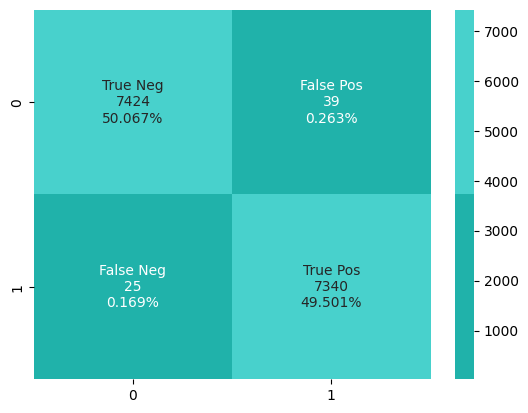

In [44]:
model_evaluation(rfc_model,X_test,y_test)

This model perfectly predicts all the outcome.

## XGBoost

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [46]:
xgb_model = XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
results.append(RunModel(xgb_model,X_train,y_train,X_test,y_test,"XGBClassifier"))

Accuracy score:  0.9779463834092059


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4894
           1       0.99      0.96      0.98      4991

    accuracy                           0.98      9885
   macro avg       0.98      0.98      0.98      9885
weighted avg       0.98      0.98      0.98      9885



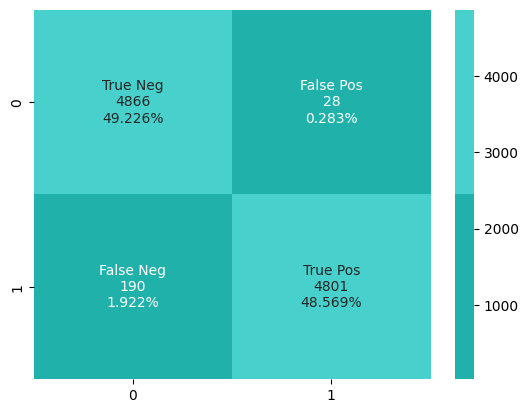

In [47]:
model_evaluation(xgb_model,X_test,y_test)

XGBoost algorithm predicts the approvals with 98% accuracy. It is highly precise but the recall is bit lower for approvals when compared. This models seems to be very efficient in predicting credit card approvals.

## Logistic Regression

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=44)

In [49]:
lr_model = LogisticRegression(C=0.8, random_state=2, solver='lbfgs')
results.append(RunModel(lr_model,X_train, y_train, X_test, y_test,"LogisticRegression"))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy score:  0.6100151745068285


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.60      0.61      0.61      4880
           1       0.62      0.61      0.61      5005

    accuracy                           0.61      9885
   macro avg       0.61      0.61      0.61      9885
weighted avg       0.61      0.61      0.61      9885



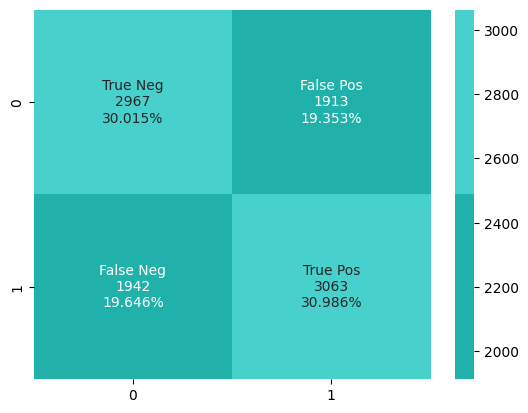

In [50]:
model_evaluation(lr_model,X_test,y_test)

The model predicts credit card approvals with 61% accuracy, but is not much good at differentiating between the target variable. This might be results of imbalanced data or model limitations.

## Support Vector Classifier

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state = 10)

In [54]:
svc_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=10,probability=True)
svc_model.fit(X_train, y_train)


SVC(probability=True, random_state=10)

In [55]:
y_pred = svc_model.predict(X_test)

# Create metric for comparison
name = "SupportVectorClassifier"
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: ",accuracy)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

auc = roc_auc_score(y_test, svc_model.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)

results.append([name, accuracy, specificity, sensitivity, auc, f1])


Accuracy score:  0.6698813056379822


              precision    recall  f1-score   support

           0       0.69      0.61      0.64      7338
           1       0.65      0.73      0.69      7490

    accuracy                           0.67     14828
   macro avg       0.67      0.67      0.67     14828
weighted avg       0.67      0.67      0.67     14828



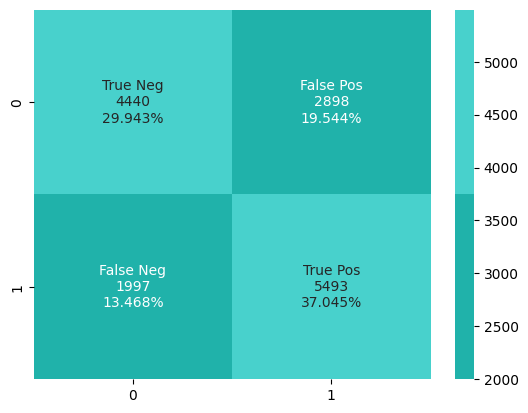

In [56]:
model_evaluation(svc_model,X_test,y_test)

In [57]:
from sklearn.ensemble import BaggingClassifier

tree_max_depth = 4
base_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=1230)
bagging_classifier_svc = BaggingClassifier(base_model)
bagging_classifier_svc.fit(X_train, y_train)
pred = bagging_classifier_svc.predict(X_test)

In [58]:
y_pred = svc_model.predict(X_test)

# Create metric for comparison
name = "BaggingClassifier_SVC"
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: ",accuracy)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
auc = roc_auc_score(y_test, bagging_classifier_svc.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)

results.append([name, accuracy, specificity, sensitivity, auc, f1])

Accuracy score:  0.6698813056379822


              precision    recall  f1-score   support

           0       0.70      0.60      0.65      7338
           1       0.66      0.74      0.70      7490

    accuracy                           0.67     14828
   macro avg       0.68      0.67      0.67     14828
weighted avg       0.68      0.67      0.67     14828



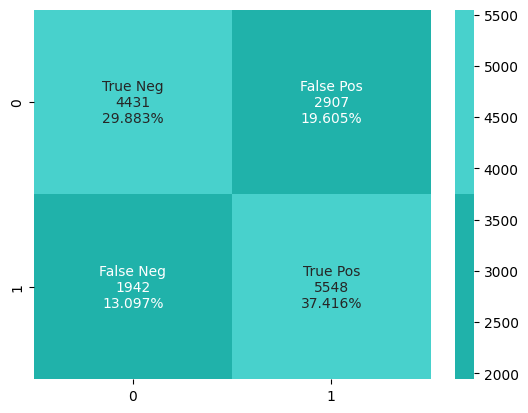

In [59]:
model_evaluation(bagging_classifier_svc,X_test,y_test)

The SVC has accuracy of 67% while predicting the credit card approval. The accuracy is not much good even after refinement we only get 66% recall.

## Analyzing models

In [60]:
df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Specificity', 'Sensitivity', 'AUC', 'F1 Score'])
print(df_results)

                     Model  Accuracy  Specificity  Sensitivity       AUC  \
0   RandomForestClassifier  0.995684     0.994774     0.996606  0.998691   
1            XGBClassifier  0.977946     0.994279     0.961931  0.997666   
2       LogisticRegression  0.610015     0.607992     0.611988  0.655087   
3     BaggingClassifier_LR  0.611836     0.608811     0.614785  0.655251   
4  SupportVectorClassifier  0.669881     0.605070     0.733378  0.738417   
5    BaggingClassifier_SVC  0.669881     0.605070     0.733378  0.695836   

   F1 Score  
0  0.995659  
1  0.977800  
2  0.613766  
3  0.615954  
4  0.691770  
5  0.691770  


The overall performance of the machine learning models used for credit card approval prediction varies greatly. Overall, XGBoost appears to be the best-performing model out of the ones we tested. We can retrain XGBoost with a larger dataset or explore techniques to improve the performance of the other models.

# DEPLOYMENT AND CONCLUSION

## Deployment

Deployment process is when we move our ML model from offline environment and integrate it into existing production environment like a live application.

There are many ways to deploy ML models like batch deployment, real-time deployment, streaming deployment, and edge deployment.

To deploy the above created credit card approval prediction model first we would need to use a cloud platform like AWS or GCP.

We would also need a monitoring infrastructure to make sure it is working as expected.

## Conclusion

In this Credit card approval prediction we have implemented various machine learning models to predict the outcome. We also found some interesting trends and evaluated the performance for all the models.
As an outcome of our EDA we found that there is high preference for approval to candidates who are females, who are married, working and have atleast secondary education. In terms of the machine learning models, the XGBoost model was the most effective in predicting outcomes and achieved high accuracy rates.
However, we can still improve the performance by improving data quality and exploring techiniques to enhance the other machine learning models like Logistic Regression and Support Vector Classifier used in this study.
